C:\Users\feder\AppData\Local\Temp\ipykernel_184304\1873916509.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrato["twoPointersAttempted"] = df_filtrato["fieldGoalsAttempted"] - df_filtrato["threePointersAttempted"]


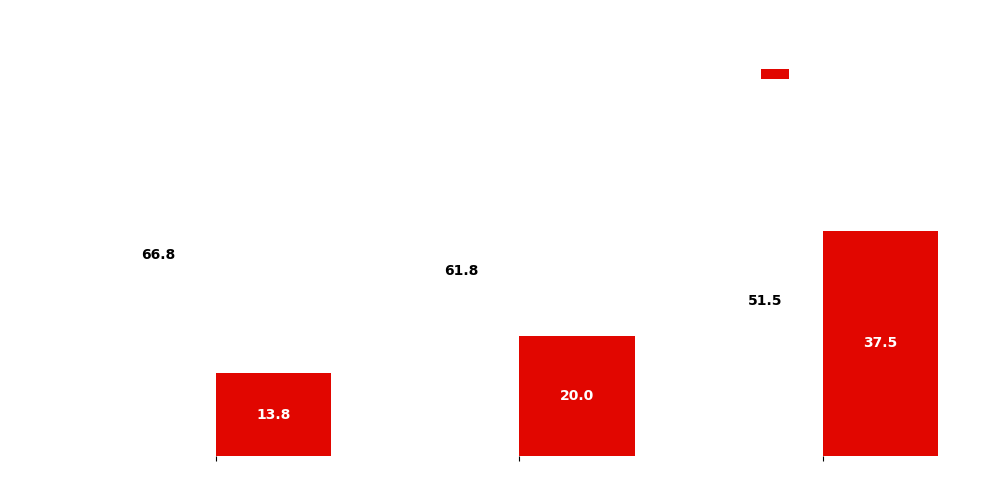

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

#LETTURA DEI FILE
df = pd.read_csv("TeamStatistics.csv",sep = ",")

#FILTRO LE COLONNE E L'ORIZZONTE TEMPORALE CHE MI INTERESSANO, FORMATTO IL DATE TIME
df = df[["gameId","gameDateTimeEst","teamCity","teamName","teamId","threePointersAttempted","threePointersMade","threePointersPercentage",
           "fieldGoalsAttempted","fieldGoalsMade","fieldGoalsPercentage","freeThrowsAttempted"]]
df["gameDateTimeEst"] = pd.to_datetime(df["gameDateTimeEst"], format="ISO8601", utc= True)


def get_season(date):
    year = date.year
    if date.month >= 10:
        return f"{year}-{str(year+1)[-2:]}"
    else:
        return f"{year-1}-{str(year)[-2:]}"

df["season"] = df["gameDateTimeEst"].apply(get_season)
df_filtrato = df[(df["season"] >= "2000-01") & (df["season"] <= "2024-25")]
df_filtrato["twoPointersAttempted"] = df_filtrato["fieldGoalsAttempted"] - df_filtrato["threePointersAttempted"]

seasons_target = ["2000-01", "2012-13", "2024-25"]
present = set(df_filtrato["season"].unique())

if "2024-25" not in present:
    seasons_target = ["2000-01", "2012-13", "2023-24"]
    print("Nota: '2024-25' non presente → uso '2023-24'.")

season_means = (
    df_filtrato[df_filtrato["season"].isin(seasons_target)]
    .groupby("season", as_index=False)
    .agg(
        twoPA=("twoPointersAttempted", "mean"),
        threePA=("threePointersAttempted", "mean"),
    )
    .sort_values("season")
)

# --- COLORI (dark background)
COL_2PA = "#B0B0B0"   # grigio
COL_3PA = "#E10600"   # rosso NBA
TEXT    = "#FFFFFF"   # bianco pieno

# --- BAR CHART
x = range(len(season_means))
width = 0.38

fig, ax = plt.subplots(figsize=(10, 5))

# sfondo trasparente 
ax.set_facecolor("none")
fig.patch.set_alpha(0)

ax.bar(
    [i - width/2 for i in x],
    season_means["twoPA"],
    width,
    label="2PA (per team-game)",
    color=TEXT
)

ax.bar(
    [i + width/2 for i in x],
    season_means["threePA"],
    width,
    label="3PA (per team-game)",
    color=COL_3PA
)

# --- valori dentro le barre
for i in range(len(season_means)):
    # 2PA (barra bianca)
    ax.text(
        i - width/2,
        season_means["twoPA"].iloc[i] / 2,
        f"{season_means['twoPA'].iloc[i]:.1f}",
        ha="center",
        va="center",
        color="#000000",      
        fontweight="bold",
        fontsize=10
    )

    # 3PA (barra rossa)
    ax.text(
        i + width/2,
        season_means["threePA"].iloc[i] / 2,
        f"{season_means['threePA'].iloc[i]:.1f}",
        ha="center",
        va="center",
        color="#FFFFFF",      
        fontweight="bold",
        fontsize=10
    )

# assi e titolo
ax.set_xticks(list(x))
ax.set_xticklabels(season_means["season"], color=TEXT, fontweight="bold")
ax.set_ylabel("Attempts per game (team)", color=TEXT, fontweight="bold")
ax.set_title(
    "Shot Trend: 2PA vs 3PA",
    color=TEXT,
    fontsize=15,
    fontweight="bold"
)

# ticks Y in grassetto
ax.tick_params(axis="y", colors=TEXT)
for label in ax.get_yticklabels():
    label.set_fontweight("bold")

# legenda
leg = ax.legend(frameon=False)
for text in leg.get_texts():
    text.set_color(TEXT)
    text.set_fontweight("bold")

# rimuovi sporcizia visiva
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(False)


plt.tight_layout()

# --- SALVATAGGIO 
fig.savefig("shot_selection_shift.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()

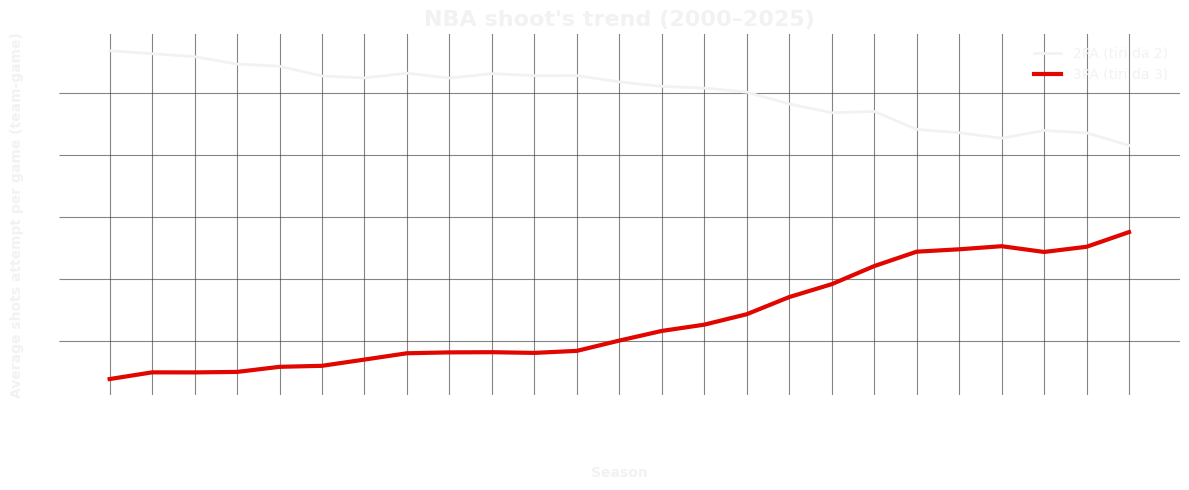

In [7]:
import matplotlib.pyplot as plt

season_trend = (
    df_filtrato.groupby("season", as_index=False)
    .agg(
        twoPA=("twoPointersAttempted", "mean"),
        threePA=("threePointersAttempted", "mean"),
        FGA=("fieldGoalsAttempted", "mean"),
    )
)

# quota di triple sul totale tiri
season_trend["three_rate"] = season_trend["threePA"] / season_trend["FGA"]

# assicuriamoci che le stagioni siano ordinate correttamente
season_trend = season_trend.sort_values("season").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 5))

# sfondo trasparente 
ax.set_facecolor("none")
fig.patch.set_alpha(0)

# colori per dark background
COL_2PA = "#B0B0B0"   
COL_3PA = "#E10600"   
TEXT   = "#F2F2F2"    
GRID   = "#333333"    
TEXT_MAIN = "#FFFFFF"   
TEXT_SUB  = "#E6E6E6"   


# linee
ax.plot(season_trend["season"], season_trend["twoPA"],
        label="2PA (tiri da 2)", color=TEXT, linewidth=2)

ax.plot(season_trend["season"], season_trend["threePA"],
        label="3PA (tiri da 3)", color=COL_3PA, linewidth=3)

# titolo e assi
ax.set_title("NBA shoot's trend (2000–2025)", color=TEXT, fontsize=16, weight="bold")
ax.set_ylabel("Average shots attempt per game (team-game)", color=TEXT, weight = "bold")
ax.set_xlabel("Season", color=TEXT , weight = "bold")

# ticks
ax.tick_params(axis="x", colors=TEXT_MAIN, rotation=45)
ax.tick_params(axis="y", colors=TEXT_MAIN)

for label in ax.get_xticklabels():
    label.set_fontweight("bold")

for label in ax.get_yticklabels():
    label.set_fontweight("bold")

# griglia soft
ax.grid(color=GRID, linewidth=0.8, alpha=0.6)

# legenda 
leg = ax.legend(frameon=False)
for t in leg.get_texts():
    t.set_color(TEXT)

# rimuovi bordi
for spine in ax.spines.values():
    spine.set_visible(False)


plt.tight_layout()

fig.savefig("shoot'strend.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()



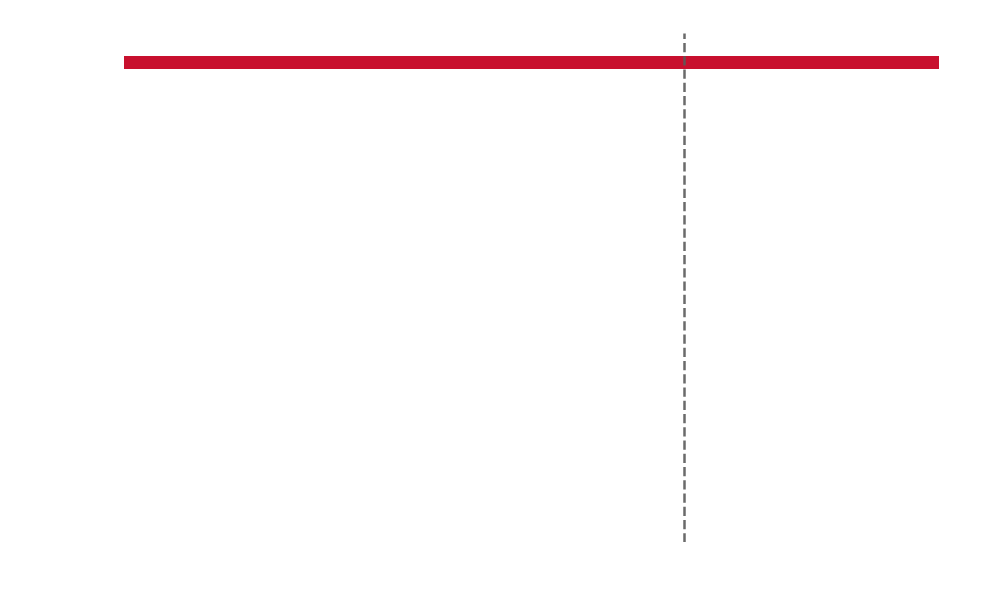

In [8]:
import matplotlib.pyplot as plt

season_target = "2017-18"

# aggregazione per squadra 
season_team = (
    df_filtrato[df_filtrato["season"] == season_target]
    .groupby("teamName", as_index=False)
    .agg(
        threePA=("threePointersAttempted", "mean"),
        threePM=("threePointersMade", "mean"),
    )
    .sort_values("threePA", ascending=False)
    .reset_index(drop=True)
)

teams = season_team["teamName"]
values = season_team["threePA"]

# palette 
ROCKETS_RED = "#C8102E"
OTHER_GREY  = "#5A5A5A"
TEXT_WHITE  = "#FFFFFF"

colors = [ROCKETS_RED if team == "Rockets" else TEXT_WHITE for team in teams]

fig, ax = plt.subplots(figsize=(10, 6))

# sfondo trasparente 
ax.set_facecolor("none")
fig.patch.set_alpha(0)

# barre
ax.barh(teams, values, color=colors)
ax.invert_yaxis()

# media lega
league_avg = season_team["threePA"].mean()
ax.axvline(league_avg, color=OTHER_GREY, linestyle="--", linewidth=1.8, alpha=0.9)

# annotazione media lega 
ax.text(
    league_avg + 0.2,
    len(teams) - 1,   # ultima barra → fondo grafico
    "League average",
    color=TEXT_WHITE,
    fontsize=10,
    fontweight="bold",
    va="bottom",
    ha="left"
)

# titolo e assi
ax.set_title(
    f"Houston Rockets — 3PA per team-game ({season_target})",
    fontsize=14,
    fontweight="bold",
    color=TEXT_WHITE
)
ax.set_xlabel("Three-point attempts per game (team)", color=TEXT_WHITE, fontweight="bold")
ax.set_ylabel("")

# ticks bianchi + bold
ax.tick_params(axis="x", colors=TEXT_WHITE)
ax.tick_params(axis="y", colors=TEXT_WHITE)

for lbl in ax.get_xticklabels():
    lbl.set_fontweight("bold")
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")

# rimuovi bordi 
for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

plt.tight_layout()

fig.savefig("rockets_outlier_2018_19.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

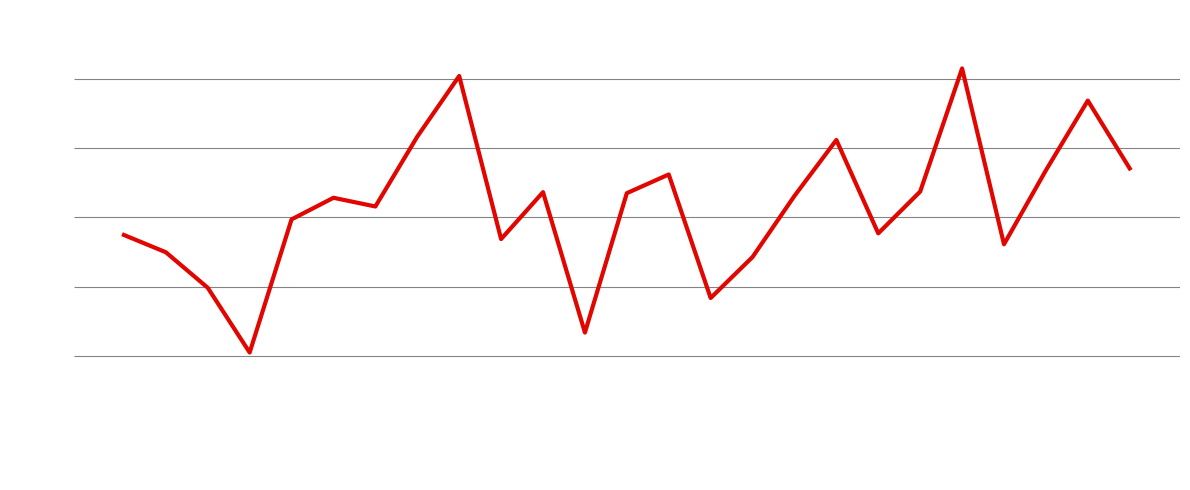

In [9]:
import matplotlib.pyplot as plt

# efficienza 3PT league-wide per stagione
three_efficiency = (
    df_filtrato
    .groupby("season", as_index=False)
    .agg(
        threePA=("threePointersAttempted", "mean"),
        threePM=("threePointersMade", "mean")
    )
)

three_efficiency["threeP_pct"] = (
    three_efficiency["threePM"] / three_efficiency["threePA"] * 100
)

three_efficiency = three_efficiency.sort_values("season").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 5))

# sfondo trasparente 
ax.set_facecolor("none")
fig.patch.set_alpha(0)

TEXT = "#FFFFFF"
RED  = "#E10600"
GRID = "#333333"

ax.plot(
    three_efficiency["season"],
    three_efficiency["threeP_pct"],
    color=RED,
    linewidth=3
)

# Zoom Y basato sui dati 
ymin = three_efficiency["threeP_pct"].min()
ymax = three_efficiency["threeP_pct"].max()
pad = (ymax - ymin) * 0.12  # 12% di margine visivo
ax.set_ylim(ymin - pad, ymax + pad)


ax.set_xticks(range(len(three_efficiency)))
ax.set_xticklabels(three_efficiency["season"], rotation=90)

# titolo e assi
ax.set_title(
    "League-wide Three-Point Shooting Efficiency (2000–2025)",
    color=TEXT, fontsize=16, fontweight="bold"
)
ax.set_ylabel("3PT Percentage (%)", color=TEXT, fontweight="bold")
ax.set_xlabel("Season", color=TEXT, fontweight="bold")

# ticks in bianco + grassetto
ax.tick_params(axis="x", colors=TEXT)
ax.tick_params(axis="y", colors=TEXT)

for lbl in ax.get_xticklabels():
    lbl.set_fontweight("bold")
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")

# stile pulito
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)



ax.grid(
    True,
    which="major",
    axis="y",          # solo griglia orizzontale 
    color="#333333",   # grigio scuro
    linewidth=0.8,
    alpha=0.6
)

plt.tight_layout()

#salvataggio
fig.savefig("three_point_efficiency.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()


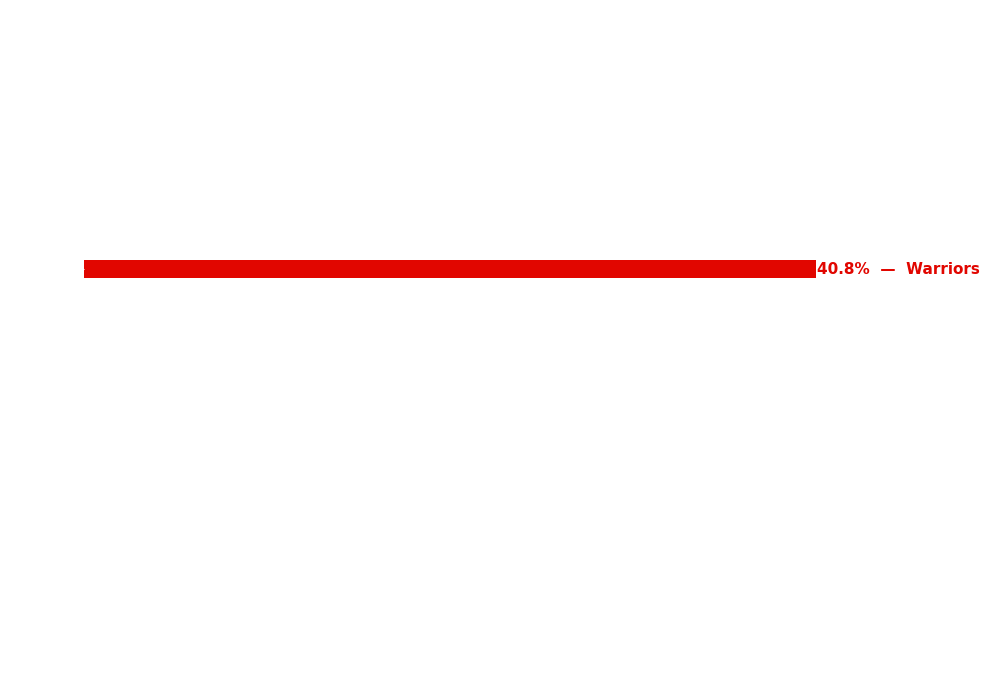

In [13]:
#ordina cronologicamente
plot_df = best_by_season.sort_values("season").reset_index(drop=True)

TEXT = "#FFFFFF"
RED  = "#E10600"
GREY = "#5A5A5A"

HIGHLIGHT_SEASON = "2015-16"

#rosso
colors = [
    RED if season == HIGHLIGHT_SEASON else TEXT
    for season in plot_df["season"]
]

fig, ax = plt.subplots(figsize=(10, 7))

#sfondo trasparente per slide nere
ax.set_facecolor("none")
fig.patch.set_alpha(0)

#barre
labels = plot_df["season"]
values = plot_df["threeP_pct"]

ax.barh(labels, values, color=colors)

#titolo e assi
ax.set_title(
    "Best team 3PT% by season (season leaders)",
    color=TEXT,
    fontsize=15,
    fontweight="bold"
)
ax.set_xlabel("3PT% (team-season aggregate)", color=TEXT, fontweight="bold")
ax.set_ylabel("")

#ticks bianchi bold
ax.tick_params(axis="x", colors=TEXT)
ax.tick_params(axis="y", colors=TEXT)
for lbl in ax.get_xticklabels():
    lbl.set_fontweight("bold")
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")

#valori e team leader a destra della barra
for i, (pct, team, season) in enumerate(
    zip(plot_df["threeP_pct"], plot_df["best_team"], plot_df["season"])
):
    is_highlight = season == HIGHLIGHT_SEASON
    ax.text(
        pct + 0.05,
        i,
        f"{pct:.1f}%  —  {team}",
        color=RED if is_highlight else TEXT,
        fontsize=11 if is_highlight else 9,
        fontweight="bold",
        va="center"
    )

#pulizia
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

# salvataggio per slide
fig.savefig("best_3pt_pct_by_season.png", dpi=300, transparent=True, bbox_inches="tight")

C:\Users\feder\AppData\Local\Temp\ipykernel_184304\805303833.py:13: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player = pd.read_csv("PlayerStatistics.csv", sep=",")
C:\Users\feder\AppData\Local\Temp\ipykernel_184304\805303833.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("autumn_r")


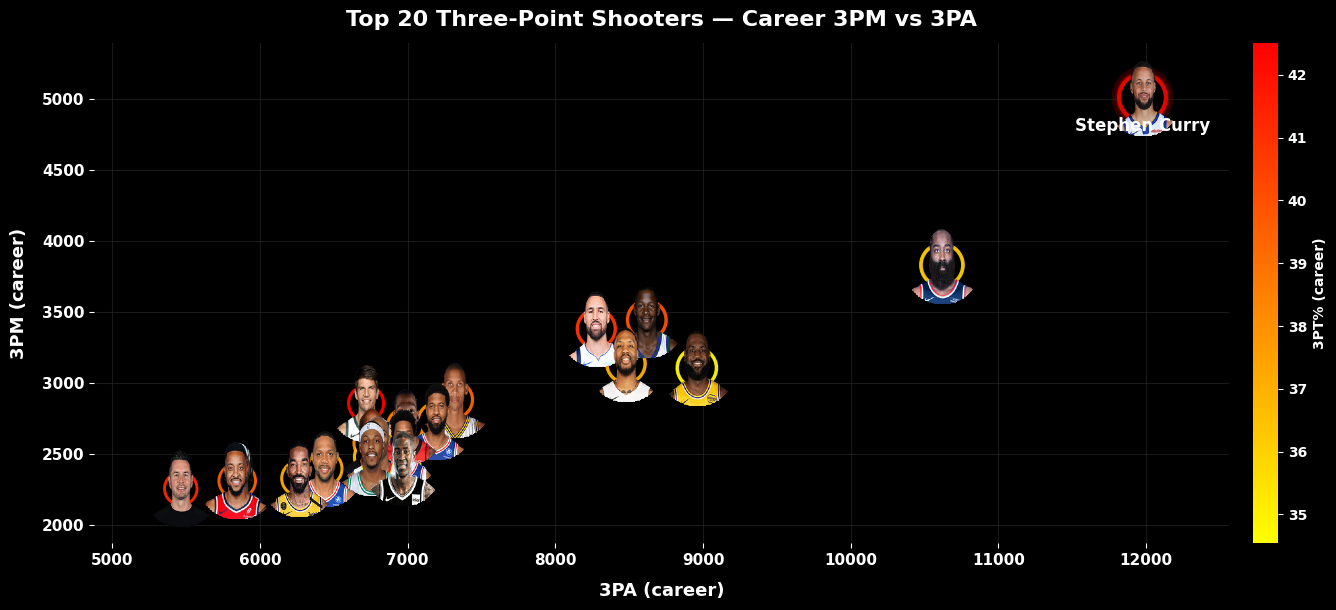

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm, colors as mcolors
from PIL import Image, ImageDraw
import requests
from io import BytesIO

# =========================
# 0) CARICA DATI
# =========================
df_player = pd.read_csv("PlayerStatistics.csv", sep=",")

df_player["playerName"] = (
    df_player["firstName"].fillna("").str.strip() + " " + df_player["lastName"].fillna("").str.strip()
).str.strip()

# =========================
# 1) AGGREGA CARRIERA
# =========================
career = (
    df_player.groupby(["personId", "playerName"], as_index=False)
    .agg(
        threePM=("threePointersMade", "sum"),
        threePA=("threePointersAttempted", "sum")
    )
)

career = career[career["threePA"] > 0].copy()
career["threeP_pct"] = (career["threePM"] / career["threePA"]) * 100

MIN_3PA = 1500
career = career[career["threePA"] >= MIN_3PA].copy()

TOP_N = 20
top = career.sort_values("threePM", ascending=False).head(TOP_N).reset_index(drop=True)

# =========================
# 2) FUNZIONI FOTO
# =========================
def nba_headshot_url(person_id: int, size="260x190") -> str:
    return f"https://cdn.nba.com/headshots/nba/latest/{size}/{person_id}.png"

def circle_crop(img: Image.Image, out_size=120) -> Image.Image:
    img = img.convert("RGBA").resize((out_size, out_size), Image.LANCZOS)
    mask = Image.new("L", (out_size, out_size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, out_size, out_size), fill=255)
    out = Image.new("RGBA", (out_size, out_size), (0, 0, 0, 0))
    out.paste(img, (0, 0), mask=mask)
    return out

_img_cache = {}
def fetch_headshot(person_id: int, out_size=120) -> Image.Image:
    key = (int(person_id), out_size)
    if key in _img_cache:
        return _img_cache[key]
    url = nba_headshot_url(int(person_id))
    try:
        r = requests.get(url, timeout=12)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content))
        img = circle_crop(img, out_size=out_size)
    except Exception:
        img = Image.new("RGBA", (out_size, out_size), (255, 255, 255, 50))
    _img_cache[key] = img
    return img

# =========================
# 3) STILE COMPATTO 16:9
# =========================
TEXT = "#FFFFFF"
GRID = "#2E2E2E"
RED  = "#E10600"

fig, ax = plt.subplots(figsize=(13.5, 6.2))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.grid(True, color=GRID, linewidth=0.8, alpha=0.55)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("3PA (career)", color=TEXT, fontweight="bold", fontsize=13, labelpad=10)
ax.set_ylabel("3PM (career)", color=TEXT, fontweight="bold", fontsize=13, labelpad=10)
ax.tick_params(axis="x", colors=TEXT, labelsize=11)
ax.tick_params(axis="y", colors=TEXT, labelsize=11)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

ax.set_title("Top 20 Three-Point Shooters — Career 3PM vs 3PA",
             color=TEXT, fontsize=16, fontweight="bold", pad=12)

# limiti con padding
x = top["threePA"].to_numpy()
y = top["threePM"].to_numpy()
xpad = (x.max() - x.min()) * 0.09
ypad = (y.max() - y.min()) * 0.14
ax.set_xlim(x.min() - xpad, x.max() + xpad)
ax.set_ylim(y.min() - ypad, y.max() + ypad)

# =========================
# 4) ANELLO = 3P% (YELLOW -> RED)
# =========================
# autumn_r: giallo -> rosso (come vuoi tu)
cmap = cm.get_cmap("autumn_r")
norm = mcolors.Normalize(vmin=top["threeP_pct"].min(), vmax=top["threeP_pct"].max())
ring_colors = [cmap(norm(p)) for p in top["threeP_pct"]]

# size per volume (3PA)
size_min, size_max = 650, 1200
s_norm = (top["threePA"] - top["threePA"].min()) / (top["threePA"].max() - top["threePA"].min() + 1e-9)
sizes = size_min + s_norm * (size_max - size_min)

# ring + inner black
ax.scatter(top["threePA"], top["threePM"], s=sizes, c=ring_colors, edgecolors="none", alpha=0.95, zorder=2)
ax.scatter(top["threePA"], top["threePM"], s=[v * 0.70 for v in sizes], c="black", edgecolors="none", zorder=3)

# =========================
# 5) HIGHLIGHT CURRY (glow + ring rosso)
# =========================
CURRY_NAME = "Stephen Curry"
curry_row = top[top["playerName"] == CURRY_NAME]

if not curry_row.empty:
    cx = float(curry_row["threePA"].iloc[0])
    cy = float(curry_row["threePM"].iloc[0])

    # glow (sotto)
    ax.scatter([cx], [cy], s=[2000], c=[RED], alpha=0.18, edgecolors="none", zorder=1)
    ax.scatter([cx], [cy], s=[1550], c=[RED], alpha=0.22, edgecolors="none", zorder=1)
    ax.scatter([cx], [cy], s=[1200], c=[RED], alpha=0.28, edgecolors="none", zorder=1)

    # ring rosso sopra (per farlo emergere)
    ax.scatter([cx], [cy], s=[1350], c=[RED], alpha=0.95, edgecolors="none", zorder=3)
    ax.scatter([cx], [cy], s=[1350 * 0.70], c=["black"], alpha=1.0, edgecolors="none", zorder=3)

# =========================
# 6) FOTO SOPRA (tutti)
# =========================
IMG_SIZE = 118
ZOOM = 0.47

for _, row in top.iterrows():
    pid = int(row["personId"])
    img = fetch_headshot(pid, out_size=IMG_SIZE)
    ab = AnnotationBbox(
        OffsetImage(img, zoom=ZOOM),
        (row["threePA"], row["threePM"]),
        frameon=False,
        zorder=5
    )
    ax.add_artist(ab)

# =========================
# 7) NOME CURRY SOTTO LA FOTO (IN BIANCO)
# =========================
if not curry_row.empty:
    # offset verticale: una frazione del range y (così scala bene)
    y_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04
    ax.text(
        cx,
        cy - y_offset,
        "Stephen Curry",
        color=TEXT,
        fontsize=12,
        fontweight="bold",
        ha="center",
        va="top",
        zorder=6
    )

# =========================
# 8) LEGENDA EFFICIENZA (COLORBAR A DESTRA)
# =========================
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("3PT% (career)", color=TEXT, fontweight="bold")
cbar.ax.yaxis.set_tick_params(color=TEXT)
plt.setp(cbar.ax.get_yticklabels(), color=TEXT, fontweight="bold")
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()

# export per slide
fig.savefig("top20_3pt_shooters_compact_curry_colorbar.png", dpi=300, bbox_inches="tight")


C:\Users\feder\AppData\Local\Temp\ipykernel_184304\2634446777.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_player = pd.read_csv("PlayerStatistics.csv", sep=",")


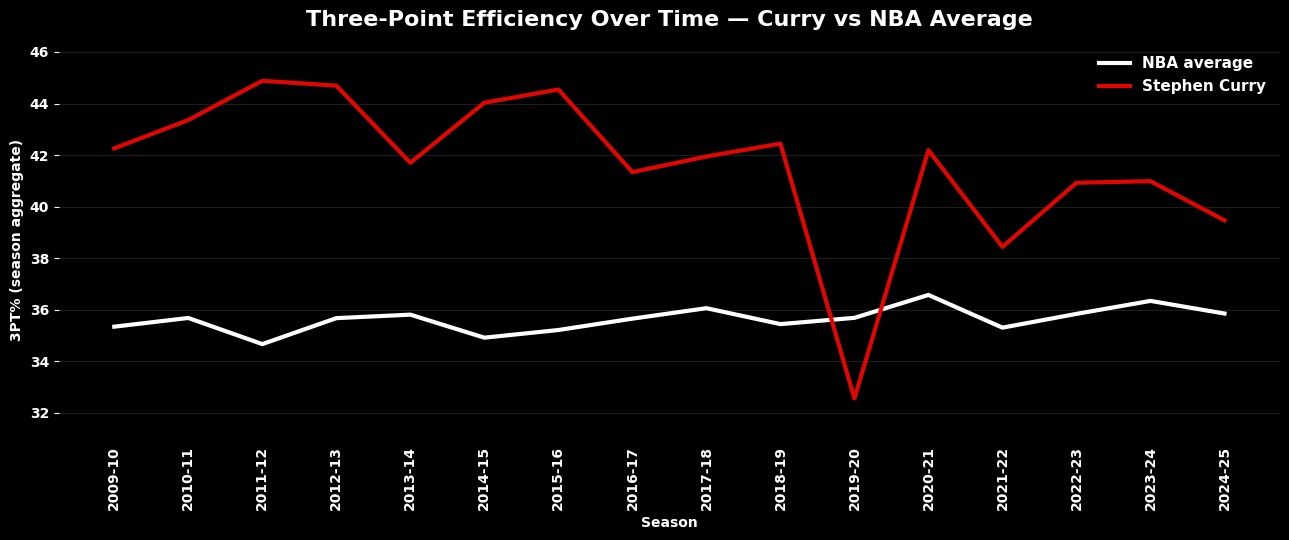

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df_player = pd.read_csv("PlayerStatistics.csv", sep=",")

df_player["playerName"] = (
    df_player["firstName"].fillna("").str.strip()
    + " "
    + df_player["lastName"].fillna("").str.strip()
).str.strip()

df_player["gameDateTimeEst"] = pd.to_datetime(df_player["gameDateTimeEst"], format="ISO8601", utc=True)

def get_season(date):
    year = date.year
    if date.month >= 10:
        return f"{year}-{str(year+1)[-2:]}"
    else:
        return f"{year-1}-{str(year)[-2:]}"

df_player["season"] = df_player["gameDateTimeEst"].apply(get_season)

# range ampio (poi tagliamo sull’era Curry)
df_player = df_player[(df_player["season"] >= "2000-01") & (df_player["season"] <= "2024-25")].copy()

CURRY_ID = 201939

# -------------------------
# League-wide (agg per season)
# -------------------------
league_season = (
    df_player.groupby("season", as_index=False)
    .agg(threePM=("threePointersMade", "sum"),
         threePA=("threePointersAttempted", "sum"))
)
league_season["league_3p_pct"] = (league_season["threePM"] / league_season["threePA"]) * 100

# -------------------------
# Curry per season
# -------------------------
curry_season = (
    df_player[df_player["personId"] == CURRY_ID]
    .groupby("season", as_index=False)
    .agg(threePM=("threePointersMade", "sum"),
         threePA=("threePointersAttempted", "sum"))
)

MIN_3PA_SEASON = 50
curry_season = curry_season[curry_season["threePA"] >= MIN_3PA_SEASON].copy()

curry_season["curry_3p_pct"] = (curry_season["threePM"] / curry_season["threePA"]) * 100

# -------------------------
# Taglio: solo dalla prima stagione NBA di Curry
# -------------------------
curry_start = curry_season["season"].min()  
league_season = league_season[league_season["season"] >= curry_start].copy()
curry_season  = curry_season[curry_season["season"] >= curry_start].copy()

# merge e sort
plot_df = (
    pd.merge(league_season[["season","league_3p_pct"]],
             curry_season[["season","curry_3p_pct"]],
             on="season", how="left")
    .sort_values("season")
    .reset_index(drop=True)
)

# -------------------------
# PLOT (dark, slide-ready)
# -------------------------
TEXT = "#FFFFFF"
RED  = "#E10600"
GREY = "#B0B0B0"
GRID = "#333333"

fig, ax = plt.subplots(figsize=(13, 5.5))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.plot(plot_df["season"], plot_df["league_3p_pct"], color=TEXT, linewidth=3, label="NBA average")
ax.plot(plot_df["season"], plot_df["curry_3p_pct"],  color=RED,  linewidth=3, label="Stephen Curry")

ax.set_title("Three-Point Efficiency Over Time — Curry vs NBA Average",
             color=TEXT, fontsize=16, fontweight="bold", pad=12)
ax.set_ylabel("3PT% (season aggregate)", color=TEXT, fontweight="bold")
ax.set_xlabel("Season", color=TEXT, fontweight="bold")

# TUTTE le season in X (solo era Curry)
ax.set_xticks(range(len(plot_df)))
ax.set_xticklabels(plot_df["season"], rotation=90, color=TEXT, fontweight="bold")
ax.tick_params(axis="y", colors=TEXT)
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")

ax.grid(True, axis="y", color=GRID, linewidth=0.8, alpha=0.6)
for spine in ax.spines.values():
    spine.set_visible(False)

leg = ax.legend(frameon=False, fontsize=11)
for t in leg.get_texts():
    t.set_color(TEXT)
    t.set_fontweight("bold")

# zoom Y coerente sui valori reali
ymin = min(plot_df["league_3p_pct"].min(), plot_df["curry_3p_pct"].min())
ymax = max(plot_df["league_3p_pct"].max(), plot_df["curry_3p_pct"].max())
pad = (ymax - ymin) * 0.12
ax.set_ylim(ymin - pad, ymax + pad)

plt.tight_layout()
plt.show()

# export
fig.savefig("curry_vs_league_3pt_efficiency_era.png", dpi=300, bbox_inches="tight")
